In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import shap
from sklearn.inspection import permutation_importance


In [ ]:
# Step 1: Load Dataset
# Load the dataset into a Pandas DataFrame
data = pd.read_csv('/content/Strokesdataset.csv')
print("Dataset loaded successfully.")
data

Dataset loaded successfully.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Female,80.0,0,1,Yes,Self-employed,Urban,67.45,25.6,never smoked,0
1,4,Female,37.0,0,0,Yes,Private,Rural,82.15,24.3,smokes,0
2,6,Female,21.0,0,0,No,Private,Urban,75.73,NaN,never smoked,0
3,7,Female,44.0,0,0,Yes,Private,Urban,222.75,19.6,never smoked,0
4,8,Female,79.0,0,0,Yes,Private,Urban,99.23,25.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,72938,Female,40.0,0,0,Yes,Private,Rural,132.52,40.1,never smoked,0
43396,72939,Female,34.0,0,0,No,Private,Urban,82.72,26.3,NaN,0
43397,72940,Female,2.0,0,0,No,children,Urban,102.92,17.6,NaN,0
43398,72941,Male,68.0,0,0,Yes,Self-employed,Urban,149.38,27.3,formerly smoked,0


In [ ]:
# Step 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(data.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB
None


In [ ]:
print("\nSummary Statistics:")
print(data.describe(include='all'))



Summary Statistics:
                  id  gender           age  hypertension  heart_disease  \
count   43400.000000   43400  43400.000000  43400.000000   43400.000000   
unique           NaN       3           NaN           NaN            NaN   
top              NaN  Female           NaN           NaN            NaN   
freq             NaN   25665           NaN           NaN            NaN   
mean    36326.142350     NaN     42.217894      0.093571       0.047512   
std     21072.134879     NaN     22.519649      0.291235       0.212733   
min         1.000000     NaN      0.080000      0.000000       0.000000   
25%     18038.500000     NaN     24.000000      0.000000       0.000000   
50%     36351.500000     NaN     44.000000      0.000000       0.000000   
75%     54514.250000     NaN     60.000000      0.000000       0.000000   
max     72943.000000     NaN     82.000000      1.000000       1.000000   

       ever_married work_type Residence_type  avg_glucose_level           bmi 

In [ ]:
print("\nMissing Values:")
print(data.isnull().sum())



Missing Values:
id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64


<ipython-input-6-4b4c94c1786d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=data, palette='viridis')


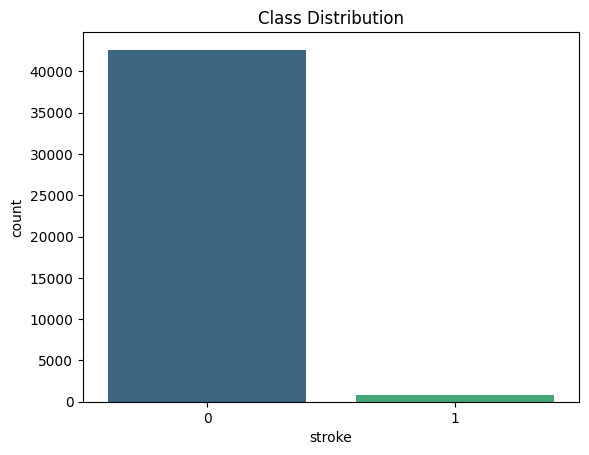

In [ ]:
# Visualize class distribution
sns.countplot(x='stroke', data=data, palette='viridis')
plt.title('Class Distribution')
plt.show()


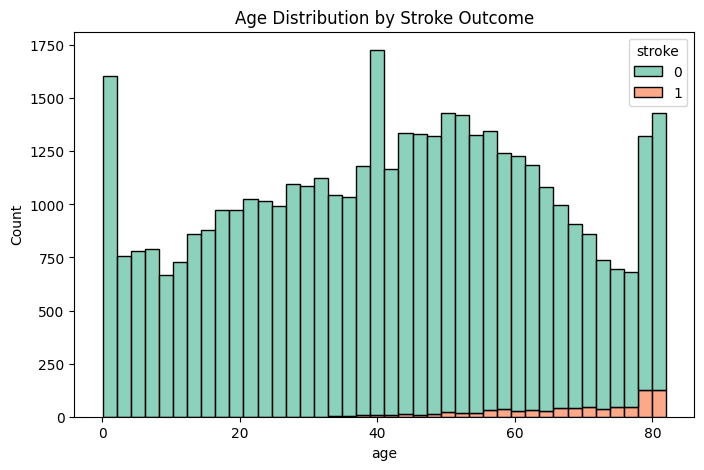

In [ ]:
# Visualization: Age distribution for stroke vs non-stroke
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='age', hue='stroke', multiple='stack', palette='Set2')
plt.title("Age Distribution by Stroke Outcome")
plt.show()

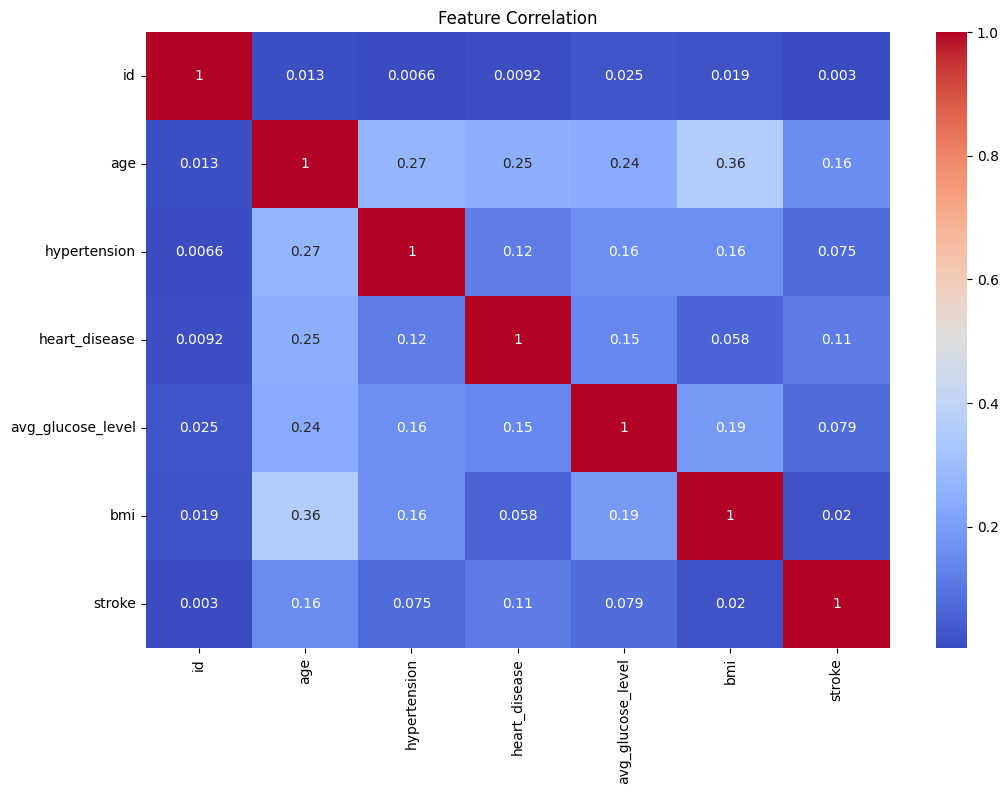

In [ ]:
# Correlation heatmap (Only numeric columns)
plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()


In [ ]:
# Step 3: Feature Engineering
# Handling missing values
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())

# Add interaction features
data['bmi_age_interaction'] = data['bmi'] * data['age']
data['age_group'] = pd.cut(data['age'], bins=[0, 18, 40, 60, 100], labels=['Child', 'Young Adult', 'Adult', 'Senior'])


In [ ]:
# One-hot encode categorical variables
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age_group']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Separate features and target
X = data.drop(columns=['stroke'])
y = data['stroke']

# Scale numeric features
scaler = StandardScaler()
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])


In [ ]:
# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 5: Handle Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
# Step 6: Model Training and Evaluation
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name} on original data...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    if y_prob is not None:
        auc_score = roc_auc_score(y_test, y_prob)
        print(f"ROC AUC Score: {auc_score:.4f}")
        results[name] = auc_score



Training Logistic Regression on original data...
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12785
           1       0.00      0.00      0.00       235

    accuracy                           0.98     13020
   macro avg       0.49      0.50      0.50     13020
weighted avg       0.96      0.98      0.97     13020

Confusion Matrix:
[[12785     0]
 [  235     0]]
ROC AUC Score: 0.8589

Training Random Forest on original data...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12785
           1       0.00      0.00      0.00       235

    accuracy                           0.98     13020
   macro avg       0.49      0.50      0.50     13020
weighted avg       0.96      0.98      0.97     13020

Confusion Matrix:
[[12785     0]
 [  235     0]]
ROC AUC Score: 0.8207

Training Support Vector Machine on original data...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12785
           1       0.00      0.00      0.00       235

    accuracy                           0.98     13020
   macro avg       0.49      0.50      0.50     13020
weighted avg       0.96      0.98      0.97     13020

Confusion Matrix:
[[12785     0]
 [  235     0]]
ROC AUC Score: 0.6352


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Permutation Importance with Best Model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")

Best Model: Logistic Regression


In [ ]:
# Summarize results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC AUC Score': list(results.values())
})

print("Model Performance Summary:")
print(results_df)

Model Performance Summary:
                    Model  ROC AUC Score
0     Logistic Regression       0.858885
1           Random Forest       0.820650
2  Support Vector Machine       0.635201


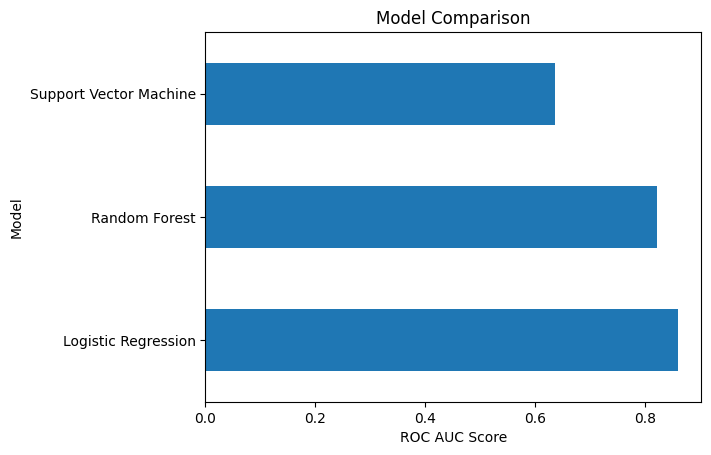

In [ ]:
# Visualize as a bar plot
results_df.set_index('Model')['ROC AUC Score'].plot(kind='barh', title='Model Comparison')
plt.xlabel('ROC AUC Score')
plt.show()

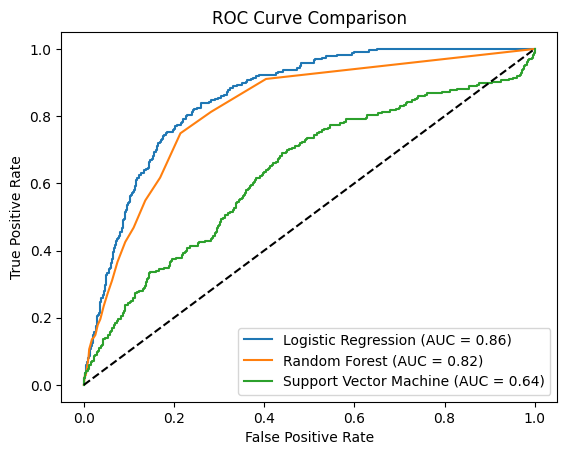

In [ ]:
# Add ROC Curves
from sklearn.metrics import roc_curve, auc

plt.figure()
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Separate the positive and negative cases
positive_sample = data[data['stroke'] == 1]
negative_cases = data[data['stroke'] == 0]

# Ensure equal numbers of positive and negative cases
sample_size = min(len(positive_sample), len(negative_cases))
negative_sample = negative_cases.sample(n=sample_size, random_state=42)

# Combine the samples to create a balanced dataset
balanced_results = pd.concat([positive_sample, negative_sample])

# Shuffle the balanced dataset
balanced_results = balanced_results.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_results


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,bmi_age_interaction,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,age_group_Young Adult,age_group_Adult,age_group_Senior
0,48798,79.0,1,0,256.52,26.3,1,2077.7,True,False,...,False,True,False,False,True,False,False,False,False,True
1,26245,82.0,1,0,81.67,21.3,1,1746.6,True,False,...,False,True,False,False,False,True,False,False,False,True
2,47333,18.0,0,0,144.55,21.6,0,388.8,False,False,...,False,True,False,False,False,False,False,False,False,False
3,21481,21.0,0,0,98.08,25.2,0,529.2,True,False,...,False,True,False,False,True,False,False,True,False,False
4,5392,69.0,0,0,97.36,28.0,1,1932.0,True,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,29653,36.0,0,0,85.02,31.4,0,1130.4,True,False,...,False,False,False,False,False,False,False,True,False,False
1562,56995,81.0,0,0,82.86,25.0,0,2025.0,False,False,...,False,True,False,False,True,True,False,False,False,True
1563,17586,12.0,0,0,81.50,16.9,0,202.8,True,False,...,False,False,False,True,True,False,False,False,False,False
1564,15132,36.0,0,0,105.27,36.4,0,1310.4,False,False,...,False,True,False,False,True,True,False,True,False,False


<ipython-input-18-f405977f562d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=balanced_results, palette='viridis')


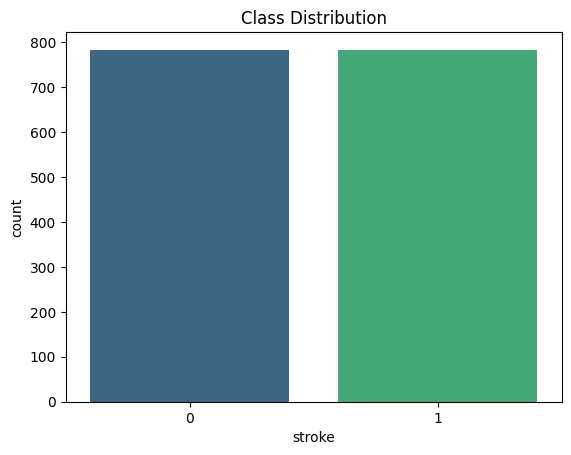

In [ ]:
# Visualize class distribution
sns.countplot(x='stroke', data=balanced_results, palette='viridis')
plt.title('Class Distribution')
plt.show()

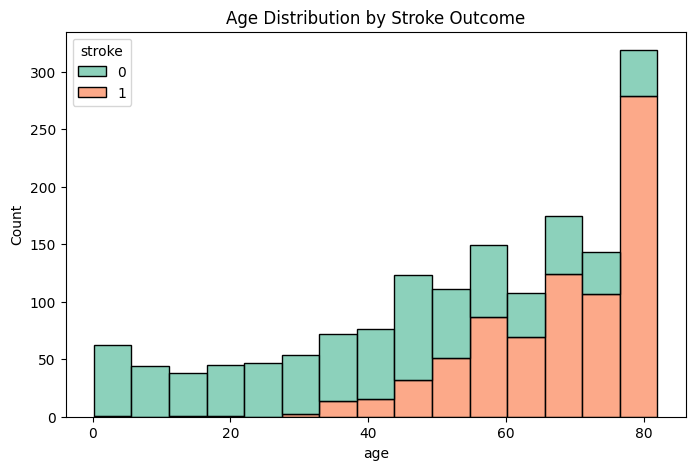

In [ ]:
# Visualization: Age distribution for stroke vs non-stroke
plt.figure(figsize=(8, 5))
sns.histplot(data=balanced_results, x='age', hue='stroke', multiple='stack', palette='Set2')
plt.title("Age Distribution by Stroke Outcome")
plt.show()

In [ ]:
# Splitting the balanced data into features and target
X_balanced = balanced_results.drop(columns=['stroke'])
y_balanced = balanced_results['stroke']

# Scaling numeric features
X_balanced[numeric_columns] = scaler.transform(X_balanced[numeric_columns])

# Train-test split for balanced data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

# Train and evaluate models on balanced data
# Train and evaluate models on balanced data
best_auc_score = 0  # Initialize best_auc_score to 0 before the loop
best_model_balanced = None   # Initialize best_model to None

for name, model in models.items():
    print(f"\nTraining {name} on balanced data...")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred_balanced = model.predict(X_test_balanced)
    y_prob_balanced = model.predict_proba(X_test_balanced)[:, 1] if hasattr(model, 'predict_proba') else None

    print("Classification Report:")
    print(classification_report(y_test_balanced, y_pred_balanced))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test_balanced, y_pred_balanced))

    if y_prob_balanced is not None:  # Use y_prob_balanced for AUC calculation on balanced data
        auc_score_balanced = roc_auc_score(y_test_balanced, y_prob_balanced)  # Calculate AUC on balanced data
        print(f"ROC AUC Score: {auc_score:.4f}")
        results[name] = auc_score

        # Check if this model has the best AUC score so far
        if auc_score_balanced > best_auc_score:
            best_auc_score = auc_score_balanced
            best_model_balanced = model  # Assign the best performing model


Training Logistic Regression on balanced data...
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       235
           1       0.75      0.87      0.81       235

    accuracy                           0.79       470
   macro avg       0.80      0.79      0.79       470
weighted avg       0.80      0.79      0.79       470

Confusion Matrix:
[[168  67]
 [ 31 204]]
ROC AUC Score: 0.6352

Training Random Forest on balanced data...
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       235
           1       0.78      0.86      0.82       235

    accuracy                           0.81       470
   macro avg       0.81      0.81      0.81       470
weighted avg       0.81      0.81      0.81       470

Confusion Matrix:
[[177  58]
 [ 32 203]]
ROC AUC Score: 0.6352

Training Support Vector Machine on balanced data...
Classification Report:
    

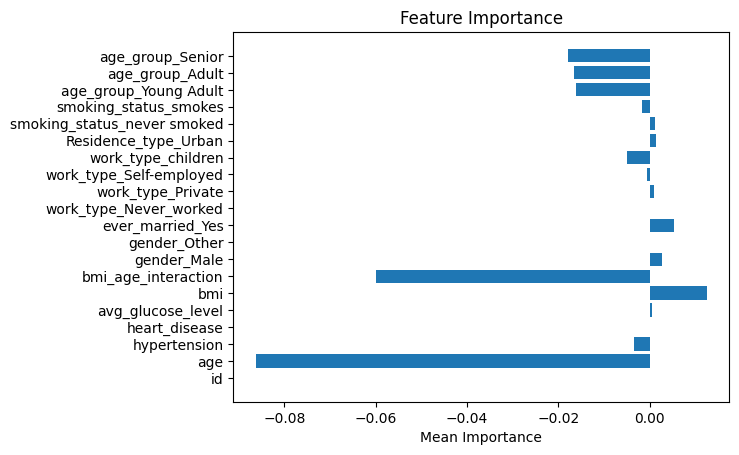

In [ ]:
# Permutation Importance
perm_importance = permutation_importance(best_model_balanced, X_test, y_test, random_state=42)
plt.barh(X_test.columns, perm_importance.importances_mean)
plt.xlabel('Mean Importance')
plt.title('Feature Importance')
plt.show()


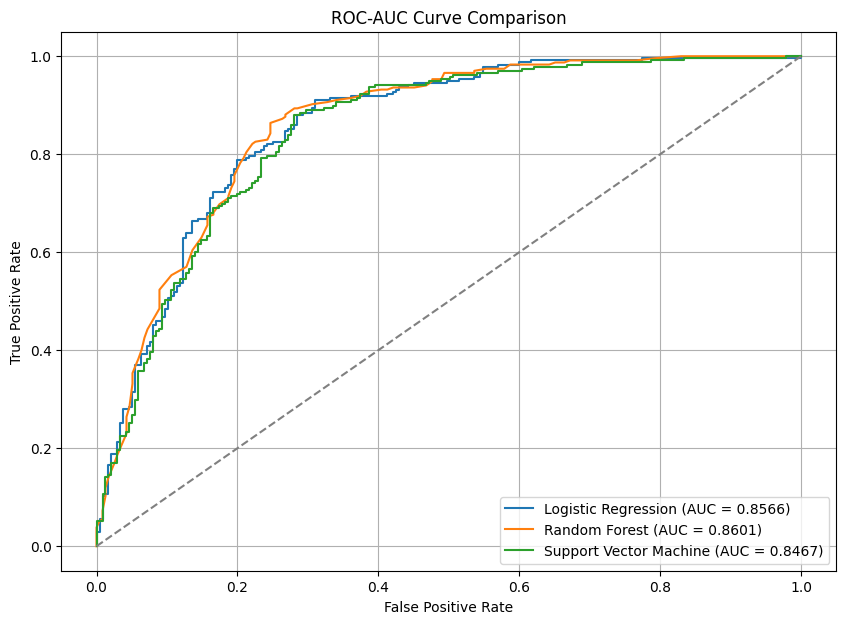

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Plot ROC-AUC curves for all models
plt.figure(figsize=(10, 7))

for name, model in models.items():
    # Check if the model has a predict_proba method and if it was evaluated on balanced data
    if hasattr(model, 'predict_proba'):
        y_prob_balanced = model.predict_proba(X_test_balanced)[:, 1]
        if y_prob_balanced is not None:
            # Compute the FPR and TPR for ROC Curve
            fpr, tpr, _ = roc_curve(y_test_balanced, y_prob_balanced)
            # Calculate and store the AUC score for the current model
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Add labels, title, and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
# Step 1: Separate Positive and Negative Cases
positive_cases = data[data['stroke'] == 1]  # Positive samples
negative_cases = data[data['stroke'] == 0]  # Negative samples

# Step 2: Ensure Positive Cases > Negative Cases
# Sample a smaller subset of negative cases
negative_sample_size = int(0.6 * len(positive_cases))  # For example, 60% of positive cases
negative_sample = negative_cases.sample(n=negative_sample_size, random_state=42)

# Combine positive cases with the reduced negative cases
imbalanced_dataset = pd.concat([positive_cases, negative_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
imbalanced_dataset


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,bmi_age_interaction,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,age_group_Young Adult,age_group_Adult,age_group_Senior
0,66955,61.0,0,1,209.86,28.605038,1,1744.907342,True,False,...,False,True,False,False,True,False,False,False,False,True
1,5436,55.0,1,0,96.71,28.605038,0,1573.277111,True,False,...,False,True,False,False,True,False,False,False,True,False
2,29539,62.0,1,0,95.49,40.200000,0,2492.400000,True,False,...,False,False,True,False,False,False,True,False,False,True
3,62526,23.0,0,0,65.49,28.700000,0,660.100000,True,False,...,False,True,False,False,False,False,False,True,False,False
4,32023,4.0,0,0,79.16,20.200000,0,80.800000,True,False,...,False,False,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,27598,7.0,0,0,80.97,16.800000,0,117.600000,False,False,...,False,False,False,True,False,False,False,False,False,False
1248,32304,31.0,0,0,97.75,30.000000,0,930.000000,True,False,...,False,True,False,False,False,False,False,True,False,False
1249,29653,36.0,0,0,85.02,31.400000,0,1130.400000,True,False,...,False,False,False,False,False,False,False,True,False,False
1250,17586,12.0,0,0,81.50,16.900000,0,202.800000,True,False,...,False,False,False,True,True,False,False,False,False,False


<ipython-input-24-3898885161c9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=imbalanced_dataset, palette='viridis')


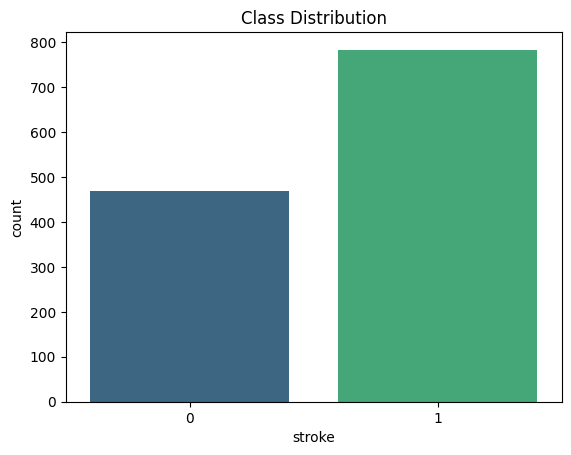

In [ ]:
# Visualize class distribution
sns.countplot(x='stroke', data=imbalanced_dataset, palette='viridis')
plt.title('Class Distribution')
plt.show()

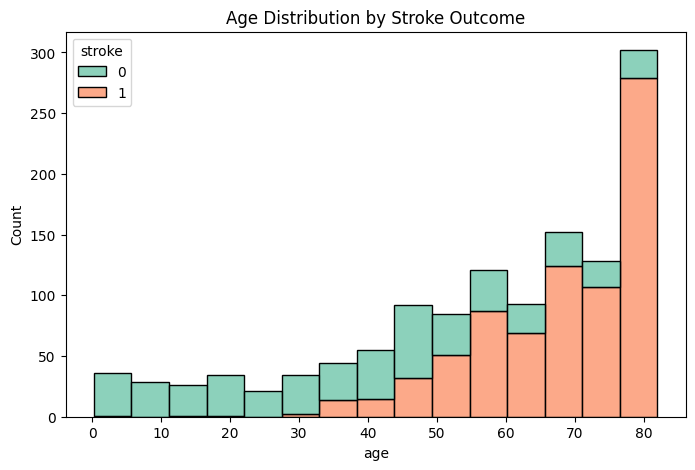

In [ ]:
# Visualization: Age distribution for stroke vs non-stroke
plt.figure(figsize=(8, 5))
sns.histplot(data=imbalanced_dataset, x='age', hue='stroke', multiple='stack', palette='Set2')
plt.title("Age Distribution by Stroke Outcome")
plt.show()

In [ ]:
# Step 3: Splitting Features and Target
X_imbalanced = imbalanced_dataset.drop(columns=['stroke'])
y_imbalanced = imbalanced_dataset['stroke']

# Step 4: Preprocessing: Scaling Numeric Columns
X_imbalanced[numeric_columns] = scaler.transform(X_imbalanced[numeric_columns])

# Step 5: Train-Test Split
X_train_imbalanced, X_test_imbalanced, y_train_imbalanced, y_test_imbalanced = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.3, random_state=42, stratify=y_imbalanced
)

# Step 6: Train and Evaluate Models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

best_model_name = None
best_model_auc = 0
best_model_instance = None
model_performance = {}

# Iterate over models
for model_name, model_instance in models.items():
    print(f"\nTraining Model: {model_name}")
    model_instance.fit(X_train_imbalanced, y_train_imbalanced)

    # Predictions
    y_pred_imbalanced = model_instance.predict(X_test_imbalanced)
    y_prob_imbalanced = None
    if hasattr(model_instance, "predict_proba"):
        y_prob_imbalanced = model_instance.predict_proba(X_test_imbalanced)[:, 1]

    # Metrics
    print("Classification Report:")
    print(classification_report(y_test_imbalanced, y_pred_imbalanced))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_imbalanced, y_pred_imbalanced))

    # Calculate AUC if probabilities exist
    if y_prob_imbalanced is not None:
        auc_score = roc_auc_score(y_test_imbalanced, y_prob_imbalanced)
        print(f"ROC AUC Score: {auc_score:.4f}")
        model_performance[model_name] = auc_score

        # Check for the best-performing model
        if auc_score > best_model_auc:
            best_model_name = model_name
            best_model_auc = auc_score
            best_model_instance = model_instance

# Step 7: Summary of Best Model
print("\nBest Performing Model:")
print(f"Model Name: {best_model_name}")
print(f"AUC Score: {best_model_auc:.4f}")



Training Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       141
           1       0.84      0.90      0.87       235

    accuracy                           0.84       376
   macro avg       0.83      0.81      0.82       376
weighted avg       0.83      0.84      0.83       376

Confusion Matrix:
[[102  39]
 [ 23 212]]
ROC AUC Score: 0.8933

Training Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       141
           1       0.84      0.90      0.87       235

    accuracy                           0.83       376
   macro avg       0.83      0.81      0.82       376
weighted avg       0.83      0.83      0.83       376

Confusion Matrix:
[[101  40]
 [ 23 212]]
ROC AUC Score: 0.8808

Training Model: Support Vector Machine
Classification Report:
              precision    recall  f1-score

In [ ]:
# Conclusion
print("\nThe study highlights the impact of balancing datasets using SMOTE on prediction models. The ROC AUC scores improved significantly after balancing.")



The study highlights the impact of balancing datasets using SMOTE on prediction models. The ROC AUC scores improved significantly after balancing.
